In [1]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from pathlib import Path
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# 解决中文乱码问题
plt.rcParams["font.sans-serif"]=["SimHei"] 
plt.rcParams["axes.unicode_minus"]=False 

In [2]:
data=pd.read_csv('./data_use.csv')
train_data,test_data=train_test_split(data,test_size=0.2, random_state=1318)
feature=train_data.drop(['Ea','Unnamed: 0'],axis=1)
label=train_data['Ea']
x_test=test_data.drop(['Ea','Unnamed: 0'],axis=1)
y_test=test_data['Ea']

In [3]:
kfold = KFold(n_splits = 5, random_state = 1314, shuffle = True)

In [4]:
def optuna_objective(trial):
    n_estimators=trial.suggest_int('n_estimators',100,500,10)
    learning_rate=trial.suggest_float('C',0.07,0.3)
    reg=XGBRegressor(n_estimators=n_estimators,learning_rate=learning_rate)
    loss=cross_val_score(reg,feature,label,cv=kfold,error_score='raise')
    return pow(abs(loss.mean()),0.5)

In [5]:
def optimizer_optuna(n_trials):
    algo=optuna.samplers.TPESampler(n_startup_trials=10,n_ei_candidates=24)
    study=optuna.create_study(sampler=algo,direction="maximize")
    study.optimize(optuna_objective,n_trials=n_trials,show_progress_bar=True)
    print("\n","\n","best params: ", study.best_trial.params,
          "\n","\n","best score: ", study.best_trial.values,
          "\n")
    
    return study.best_trial.params, study.best_trial.values

In [6]:
optimizer_optuna(100)

[I 2023-05-01 15:02:35,253] A new study created in memory with name: no-name-4edf3961-4e9f-4e4b-864c-9b9af68c566c
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-05-01 15:02:35,953] Trial 0 finished with value: 0.8207732699666608 and parameters: {'n_estimators': 210, 'C': 0.24695402757518048}. Best is trial 0 with value: 0.8207732699666608.
[I 2023-05-01 15:02:36,507] Trial 1 finished with value: 0.8193220540686365 and parameters: {'n_estimators': 190, 'C': 0.26486643065140036}. Best is trial 0 with value: 0.8207732699666608.
[I 2023-05-01 15:02:37,445] Trial 2 finished with value: 0.8085432215007486 and parameters: {'n_estimators': 340, 'C': 0.14362920927835804}. Best is trial 0 with value: 0.8207732699666608.
[I 2023-05-01 15:02:38,628] Trial 3 finished with value: 0.8171308727182829 and parameters: {'n_estimators': 450, 'C': 0.16558864527153339}. Best is trial 0 with value: 0.8207732699666608.
[I 2023-05-01 15:02:39,102] Trial 4 finished with value: 0.8176251360056286 and parameters: {'n_estimators': 150, 'C': 0.272102751851127}. Best is trial 0 with value: 0.8207732699666608.
[I 2023-05-01 15:02:40,511] Trial 5 finished with value: 

({'n_estimators': 310, 'C': 0.29130897518421417}, [0.8255446907061929])

In [7]:
model = XGBRegressor(n_estimators=2000,booster='gblinear',learning_rate=0.24).fit(X=feature , y=label)
r2_score = cross_val_score(model, feature, label, cv=kfold, scoring='r2').mean()
rmse_score = pow(abs(cross_val_score(model, feature, label, cv=kfold, scoring='neg_mean_squared_error').mean()),0.5)
print('r2:',r2_score)
print('rmse:',rmse_score)

r2: 0.6965047204603136
rmse: 0.1934828649172232


In [8]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
print('r2:',r2_score(label,model.predict(feature)))
print('MAE:',mean_absolute_error(label,model.predict(feature)))
print('测试集得分为：', r2_score(y_test,model.predict(x_test)),mean_absolute_error(y_test,model.predict(x_test)))

r2: 0.8201384297188843
MAE: 0.11665908297044891
测试集得分为： 0.80199512159288 0.12626426250594003


In [9]:
# 预测1
Y1=model.predict(test_data.drop(['Ea','Unnamed: 0'],axis=1))
Y2=test_data['Ea']
d={'Y_pred':Y1,
   'Y_True':Y2
   }
pred_show=pd.DataFrame(d)

In [10]:
# 预测2
Y_1=model.predict(feature)
Y_2=label
d_1={'Y_pred':Y_1,
   'Y_True':Y_2
   }
pred_show_1=pd.DataFrame(d_1)

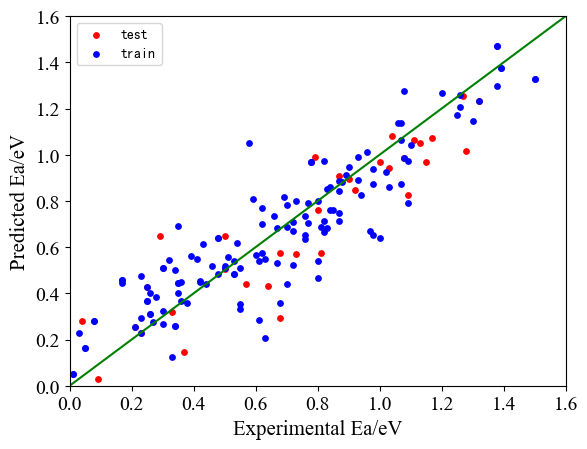

In [11]:
plt.scatter(pred_show.iloc[:,1],pred_show.iloc[:,0],color='r',s=15,label='test')
plt.scatter(pred_show_1.iloc[:,1],pred_show_1.iloc[:,0],color='b',s=15,label='train')
plt.xlim((0,1.6))
plt.xlabel('Experimental Ea/eV',fontsize=15,font=Path('..\TimesNewRoman.ttf'))
plt.xticks(fontsize=14,fontname='Times New Roman')
plt.ylim((0,1.6))
plt.ylabel('Predicted Ea/eV',fontsize=15,font=Path('..\TimesNewRoman.ttf'))
plt.yticks(fontsize=14,fontname='Times New Roman')
plt.plot([0,1.6],[0,1.6],color='g')
# plt.text(40,92,'Ridge',fontsize=20,font=Path('..\TimesNewRoman.ttf'))
plt.legend()
plt.show()

In [12]:
# 预测2
Y_1=model.predict(feature)
Y_2=label
d_1={'Y_pred':Y_1,
   'Y_True':Y_2
   }
pred_show_1=pd.DataFrame(d_1)